In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [2]:

IMG_SIZE = 224
batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

labels = ds_info.features['label'].names

# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [3]:
saved_model = tf.keras.models.load_model('../tf_models/colab/best_colab1_fine.h5', compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
saved_model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [4]:
saved_model.evaluate(ds_test)

134/134 [==============================] - 283s 2s/step - loss: 0.7003 - accuracy: 0.7948


[0.7003371119499207, 0.7947761416435242]

31-border_terrier: 0.0784178227186203
45-miniature_schnauzer: 0.34337544441223145
4-shih: 0.4677117168903351


Text(0.5, 1.0, 'shih')

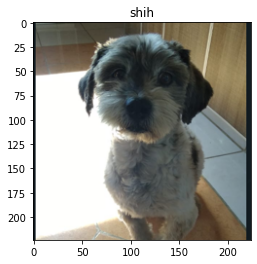

In [33]:
from PIL import Image
label_info = ds_info.features["label"]
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

img = np.array(Image.open('../data/test_data/jack1.png').resize((224,224)), dtype=np.float32) #/ 255.0
pred = saved_model.predict(img.reshape(-1, 224, 224, 3))
breeds = np.argsort(pred, axis=1)[0, -3:]
for b in breeds:
    print(f'{b}-{format_label(b)}: {pred[0,b]}')

plt.imshow(img.astype("uint8"))
plt.title("{}".format(format_label(np.argmax(pred))))